# How are Public Urban Green Spaces mapped in OSM?

In this analysis we will look at how urban green spaces such as parks are mapped in OSM in three different cities: **London, Berlin** and **Tokyo**. The boundaries of the three cities are defined as circles around the center of the cities with a radius of 10 km. 

In [1]:
radius = 10000
cities = {"Tokyo": [139.7594549, 35.6828387, radius], # lon, lat, radius
          #"Berlin": [13.3888599, 52.5170365, radius],
          "London": [-0.1276474, 51.5073219, radius],
          #"Istanbul": [28.979530, 41.015137, radius],
          "Vienna": [16.373819, 48.208176, radius], 
          "Kathmandu": [85.300140, 27.700769, radius]
         }

There many different tags to map public green spaces in OSM. In this analysis, we will focus on: 

In [2]:
tags = ["leisure=park", "leisure=garden", "landuse=grass", "landuse=village_green"]

##### Import modules

In [3]:
import sys
sys.path.append('..')

In [4]:
import ohsome
import geopandas as gpd
import pandas as pd
import yaml
from utils import load_config_yaml
import matplotlib.pyplot as plt
import mplleaflet
import seaborn as sns
from shapely.geometry import box, Polygon, MultiPolygon
import utm

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
sns.set_theme(style="ticks", palette="pastel")

## 1. Which tags are used to map public green spaces? 

First, we will look at how often the three tags occurr within the three cities and how it evolved over time. 

In [7]:
client = ohsome.OhsomeClient()

In [8]:
time =  "{}/{}/P1Y".format(client.start_timestamp.isoformat(), client.end_timestamp.isoformat())

In [9]:
data = []
for tag in tags:
    print("Processing {} ...".format(tag))
    response = client.elements.count.groupByBoundary.post(bcircles=cities, 
                                                       time=time, 
                                                       filter="{} and type:way".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
greenspace_count = pd.concat(data, axis=1)

Processing leisure=park ...
Processing leisure=garden ...
Processing landuse=grass ...
Processing landuse=village_green ...


In [10]:
greenspace_count.head()

leisure=park  leisure=garden  \
boundary  timestamp                                                 
Kathmandu 2007-10-08 00:00:00+00:00           0.0             0.0   
          2008-10-08 00:00:00+00:00           1.0             1.0   
          2009-10-08 00:00:00+00:00           4.0             0.0   
          2010-10-08 00:00:00+00:00           4.0             0.0   
          2011-10-08 00:00:00+00:00           9.0             1.0   

                                     landuse=grass  landuse=village_green  
boundary  timestamp                                                        
Kathmandu 2007-10-08 00:00:00+00:00            0.0                    0.0  
          2008-10-08 00:00:00+00:00            0.0                    0.0  
          2009-10-08 00:00:00+00:00            0.0                    0.0  
          2010-10-08 00:00:00+00:00            0.0                    0.0  
          2011-10-08 00:00:00+00:00            0.0                    1.0

The dataframe contains a `MultiIndex` based on the city and the timestamp to identify the rows. 

### 1.0 How many public green spaces have been mapped in each city?

In [11]:
latest_timestamp = greenspace_count.index.get_level_values(1)[-1]
latest = greenspace_count.loc[(slice(None), [latest_timestamp]), :].droplevel(1)

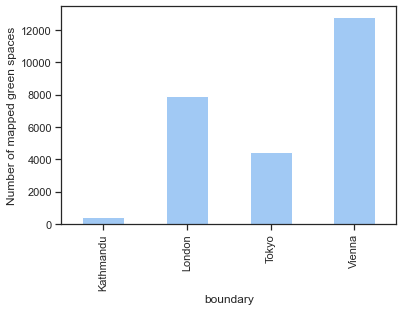

In [12]:
latest.sum(axis=1).plot(kind="bar", ylabel="Number of mapped green spaces")

### 1.1 Which tags have been used to map public green spaces in each city?

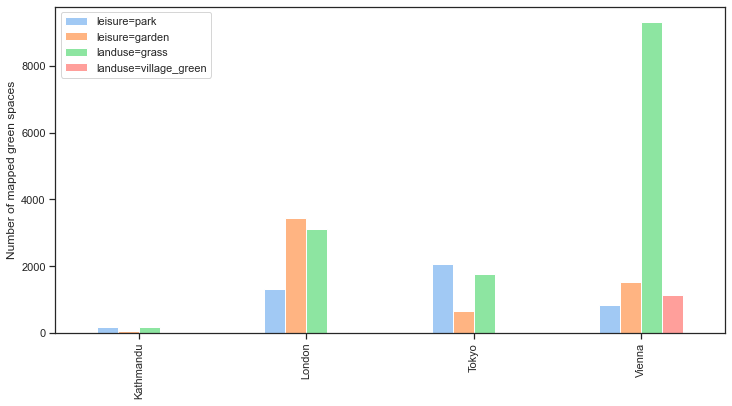

In [13]:
latest.plot(kind="bar", figsize=(12,6), xlabel="", ylabel="Number of mapped green spaces")

### 1.2 How did this change over time? 

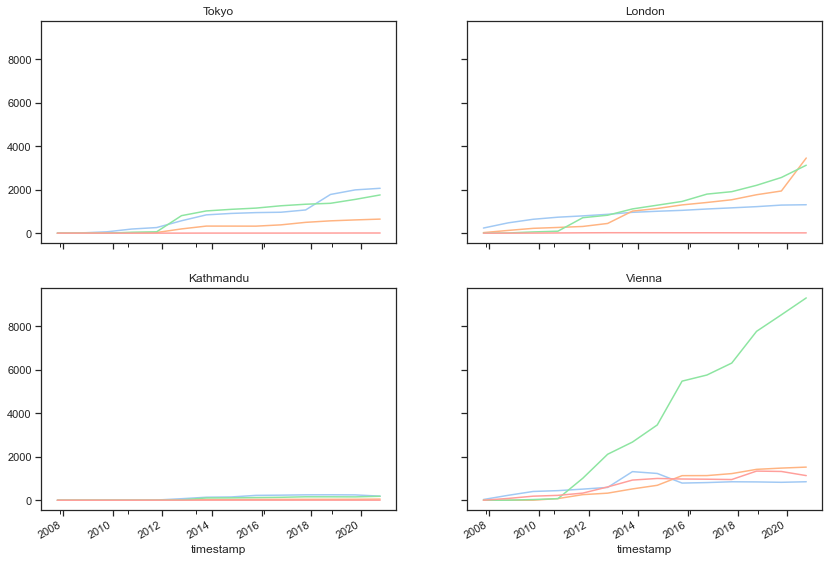

In [14]:
fig, axes = plt.subplots(2,2, figsize=(14,10), sharey=True, sharex=True)
greenspace_count.loc["Tokyo", :].plot(kind="line", ax=axes[0][0], legend=False, title="Tokyo")
greenspace_count.loc["London", :].plot(kind="line", ax=axes[0][1], legend=False, title="London")
greenspace_count.loc["Kathmandu", :].plot(kind="line", ax=axes[1][0], legend=False, title="Kathmandu")
greenspace_count.loc["Vienna", :].plot(kind="line", ax=axes[1][1], legend=False, title="Vienna")

## 2. How many users have been mapping green spaces?

Query the number of users who have mapped green spaces:

In [15]:
fltr = "({}) and type:way".format(" or ".join(tags))
response_users_gs = client.users.count.groupByBoundary.post(bcircles=cities, 
                                                       time=time, 
                                                       filter=fltr)

In [16]:
users_greenspace = response_users_gs.as_dataframe().droplevel("fromTimestamp").rename(columns={"value": "greenspace"})

Query the number of all active users (relations are excluded to save computation time)

In [17]:
response_users_all = client.users.count.groupByBoundary.post(bcircles=cities, 
                                                       time=time, 
                                                       filter="type:node or type:way")

In [18]:
users = response_users_all.as_dataframe().droplevel("fromTimestamp").rename(columns={"value": "overall"})
users = users.join(users_greenspace)
users["perc"] = users["greenspace"] / users["overall"] * 100

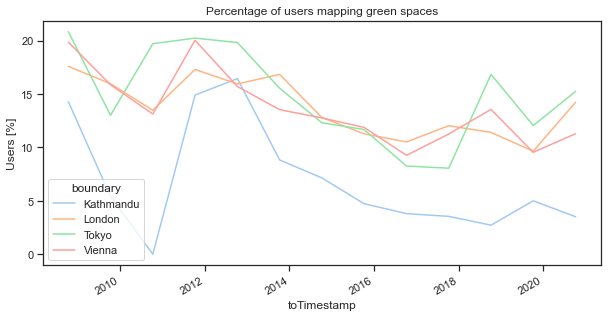

In [19]:
users.loc[:, "perc"].unstack(0).plot(title="Percentage of users mapping green spaces", 
                                     figsize=(10, 5), ylabel="Users [%]", )

## 2. What OSM keys are mapped inside green spaces? 

In order to answer this question we first have to download the geometries of the public green spaces in OSM.

#### Download OSM green spaces

In [20]:
def reproject_to_utm(dataframe):
    """ Reproject a dataframe with epsg:4326 to UTM in respective zone
    Reprojects a dataframe to UTM
    :param dataframe:
    :return:
    """
    center = box(*dataframe.total_bounds).centroid
    utm_zone = utm.from_latlon(center.y, center.x)
    proj4_string = '+proj=utm +zone=%s +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0' % utm_zone[2]

    return dataframe.to_crs(proj4_string)

In [21]:
greenspace_objects = {}
for city, bcircles in cities.items():
    print("Processing {} ...".format(city))
    response_geometry = client.elements.geometry.post(bcircles=bcircles, 
                                                       time=client.end_timestamp, 
                                                       properties="tags",
                                                       filter="({}) and type:way".format(" or ".join(tags)))
    greenspace_city = response_geometry.as_geodataframe().droplevel(1)#.loc[:,["leisure", "landuse", "geometry"]]
    greenspace_city["area"] = reproject_to_utm(greenspace_city).area
    # Create tag column
    tag_series = []
    for tag in tags:
        k, v = tag.split("=")
        tag_series.append(pd.Series(tag, greenspace_city.loc[greenspace_city[k] == v].index))
    tag_series = pd.concat(tag_series, axis=0)
    greenspace_city["tag"] = tag_series[~tag_series.index.duplicated(keep='first')]
    greenspace_objects[city] = greenspace_city.loc[:,["tag", "area", "geometry"]]
    
greenspaces = pd.concat(greenspace_objects.values(), axis=0, keys=greenspace_objects.keys(), names=["boundary", "@osmId"])

Processing Tokyo ...
Processing London ...
Processing Vienna ...
Processing Kathmandu ...


### Does the different tags used for green spaces of different size?

In [22]:
greenspace_size = greenspaces.droplevel("@osmId").set_index('tag', append=True)
greenspace_size = greenspace_size.loc[(slice(None), tags), :]

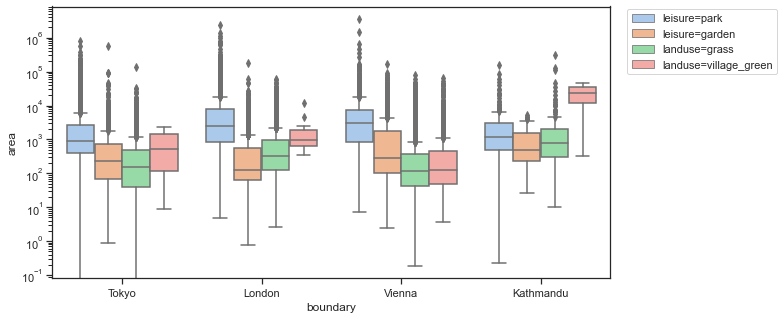

In [23]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x="boundary", y="area", hue="tag",data=greenspace_size.reset_index(), ax=axes)
axes.set(yscale="log")
axes.legend(loc=(1.03, 0.75), title_fontsize="x-large")

It seems like larger green space are usually tagged as _leisure=park_ while smaller ones are tagged as _leisure=garden_ or _landuse=grass_. In Kathmandu however, green spaces tagged as *leisure=village_green* have the biggest size. 

### Which objects are mapped within green spaces?

In [24]:
search_osm_keys = ["amenity", "leisure", "natural", "highway"]

In [25]:
def count_tags_within_greenspaces(city, tag, time, groupByKeys):
    subset = greenspace_size.sort_index().loc[city, tag]
    subset = subset.loc[subset.geometry.apply(lambda x: isinstance(x, Polygon ) or isinstance(x, MultiPolygon))]
    samples = subset.sample(min(250, len(subset)), random_state=51)
    fltr = "({}) and (type:way or type:node)".format(" or ".join([x + "=*" for x in groupByKeys]))
    response_park = client.elements.count.groupByKey.post(bpolys=samples, 
                                                       time=time, 
                                                       groupByKeys=groupByKeys,
                                                       filter=fltr)
    return response_park.as_dataframe()

In [26]:
data_cities = {}
for city in cities.keys():
    print("Processing " + city + "...")
    data_tags = {}
    for tag in tags:
        data_tags[tag] = count_tags_within_greenspaces(city, tag, client.end_timestamp, search_osm_keys)
    df_tags = pd.concat(data_tags.values(), axis=0, keys=data_tags.keys()).droplevel(2)
    data_cities[city] = pd.DataFrame(df_tags.unstack())
df_cities = pd.concat(data_cities.values(), axis=0, keys=data_cities.keys()).stack()

Processing Tokyo...
Processing London...
Processing Vienna...
Processing Kathmandu...


Text(0.5, 1.0, 'Vienna')

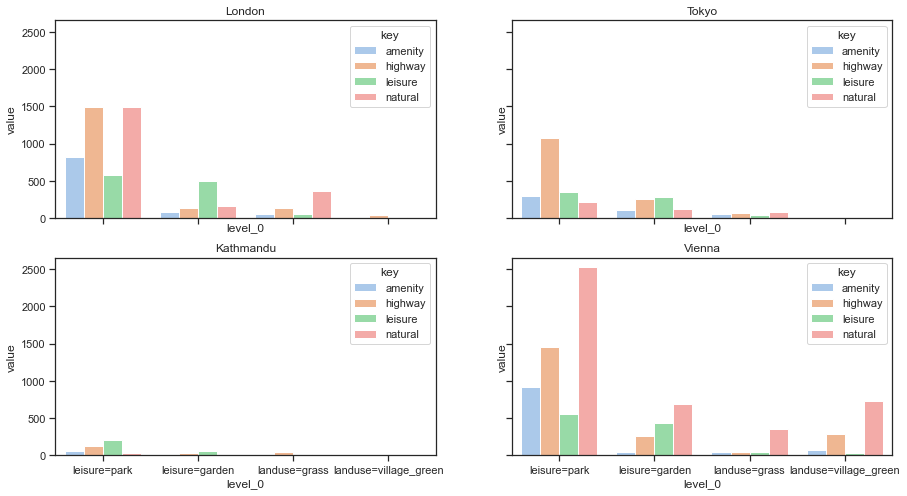

In [27]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True, sharey=True)
sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["London"].reset_index(), ax=axes[0][0])
axes[0][0].set_title("London")
sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["Tokyo"].reset_index(), ax=axes[0][1])
axes[0][1].set_title("Tokyo")
sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["Kathmandu"].reset_index(), ax=axes[1][0])
axes[1][0].set_title("Kathmandu")
sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["Vienna"].reset_index(), ax=axes[1][1])
axes[1][1].set_title("Vienna")
#sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["Berlin"].reset_index(), ax=axes[0][0])
#sns.barplot(x="level_0", y="value", hue="key", data=df_cities.loc["Kathmandu"].reset_index(), ax=axes[2][1])

Green spaces tagged as _leisure=park_ contain a lot of objects such as benches, playgrounds or garbage bins. Green spaces with other tags contain usually very few objects.  